In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import copy
import os

In [59]:
def Relu(Score): 
    T = np.maximum(0, Score)
    return T

def Softmax(scores):
    probs = np.exp(scores)
    probs /= np.sum(probs, keepdims=True)
    return np.array(probs)

def DNLL(Scores , correctClass):
    Scores[0][correctClass] = Scores[0][correctClass] - 1
    return Scores

In [11]:
def Encoding(Labels):
    Encoded = []
    T = {"daisy":0, "dandelion":1, "roses":2, "sunflowers":3, "tulips":4}
    for i in Labels: 
        Encoded.append(T[i])
    return np.array(Encoded)

In [12]:
class NeuralNetwork: 
    def __init__ (self, HiddenLayers, Neurons): 
        self.NeuralNetwork = []
        self.HiddenLayers = HiddenLayers
        self.Neurons = Neurons
        self.weights = []
        self.OutputLayer = np.zeros(5).reshape(-1,5)
        self.InputLayer = np.zeros(3072).reshape(-1,3072)
        
        self.NeuralNetwork.append(self.InputLayer)
        for i in range(self.HiddenLayers): 
            HiddenLayer = np.zeros(self.Neurons[i]).reshape(-1, Neurons[i])
            self.NeuralNetwork.append(HiddenLayer)
        self.NeuralNetwork.append(self.OutputLayer)
        
    def RGL(self , Regularization): 
        self.RegLoss = 0; 
        for W in self.weights[0]: 
            self.RegLoss += 0.5 * Regularization * np.sum(W*W)
        return self.RegLoss
        
    def SetInput(self, IN): 
        self.NeuralNetwork[0] = IN
        
    def WeightIntialization(self):
        for i in range(len(self.NeuralNetwork)-1): 
            D = self.NeuralNetwork[i].shape[1]
            H = self.NeuralNetwork[i+1].shape[1]
            W = np.random.randn(D,H)/np.sqrt(D)
            self.weights.append(W)
        self.weights = np.array(self.weights)
        
    def BiasIntialization(self):
        self.Bias = []
        for i in range(len(self.NeuralNetwork)-1):
            B = np.zeros((1,self.NeuralNetwork[i+1].shape[1]))
            self.Bias.append(B)
        
    def WeightGradientIntialization(self):
        self.DW = []
        for i in self.weights:
            temp = np.zeros(i.shape)
            self.DW.append(temp)
            
    def ScoresGradientIntialization(self):
        self.DLayers = []        
        for i in range(1, len(self.NeuralNetwork)):
            temp = np.zeros(self.NeuralNetwork[i].shape)
            self.DLayers.append(temp)
    
    def BiasGradientIntialization(self): 
        self.DB = []
        for i in self.Bias: 
            temp = np.zeros(i.shape)
            self.DB.append(temp)

In [13]:
class NeuralNetworkTrain: 
    def __init__(self, NeuralNetwork , Weights , Bias):
        self.NeuralNetwork = NeuralNetwork
        self.Weights = Weights
        self.Bias = Bias
    
    def UpdateWeights(self , LearningRate , DW): 
        for i in range(len(self.Weights)): 
            self.Weights[i]+= -LearningRate * DW[i]
        return self.Weights
    
    def UpdateBias(self , LearningRate , DB): 
        for i in range(len(self.Bias)): 
            self.Bias[i] += -LearningRate * DB[i]
        return self.Bias
    
    def UpdateGradients(self,DW, D_Weights , Regularization):
        D_Weights = D_Weights[::-1]
        for i in range(len(D_Weights)):
            DW[i] += D_Weights[i]
        for i in range(len(self.Weights)): 
            DW[i] += Regularization * self.Weights[i]
        return DW
    
    def ForwardPass(self):
        for i in range(len(self.NeuralNetwork) - 1):
            temp = np.dot(self.NeuralNetwork[i], self.Weights[i])  + self.Bias[i]
            if i+1 == len(self.NeuralNetwork) - 1:
                self.NeuralNetwork[i+1]= Softmax(temp)
            else:
                self.NeuralNetwork[i+1]= Relu(temp)
    
    def BackPropagation(self , CorrectClass):
        self.CorrectClass = CorrectClass
        D_Scores = []
        D_Weights = []
        D_Bias = []
        count = 0
        for i in range(len(self.NeuralNetwork)-1 , 0 , -1): 
            if i == len(self.NeuralNetwork)-1: #Last Layer
                X = DNLL(self.NeuralNetwork[i] , self.CorrectClass)
                Y = np.dot(self.NeuralNetwork[i-1].T , X)
                Z = np.sum(X, keepdims = True)
                D_Scores.append(X)
                D_Weights.append(Y)
                D_Bias.append(Z)
                count+=1
            else: 
                X = np.dot(D_Scores[count-1] , self.Weights[i].T)
                X[self.NeuralNetwork[i] <= 0] = 0                     #DRELU
                Y = np.dot(self.NeuralNetwork[i-1].T ,X)
                Z = np.sum(X, keepdims = True)
                D_Scores.append(X)
                D_Weights.append(Y)
                D_Bias.append(Z)
                count+=1
        return D_Weights , D_Bias

In [14]:
def ZeroCenter(PicSet):
    PicSet -= np.mean(PicSet, axis = 0)
    return PicSet

In [15]:
def AverageGradient(Gradients , BatchSize): 
    Gradients[0] /= BatchSize
    return Gradients

In [16]:
def loadpics(datapath):
    dimensions = (32 , 32)
    testset = list()
    trainingset = list()
    testlabels = list()
    trainglabels = list()
    for folder in os.listdir(datapath):
        test = list()
        labels = list()
        for image in os.listdir(os.path.join(datapath, folder)):
            sub = os.path.join(datapath,folder)
            imagename = os.path.join(sub , image)
            i = Image.open(imagename)
            i = i.resize(dimensions)
            test.append(np.reshape(np.asarray(i) ,(3,dimensions[0],dimensions[1])).transpose(1,2,0))
            labels.append(folder)
            
            
        trainingset.extend(test[:len(test)-134])
        testset.extend(test[-134:])
        
        trainglabels.extend(labels[:len(labels)-134])
        testlabels.extend(labels[-134:])
    
    
    trainingset = np.array(trainingset, dtype = "float64")
    testset = np.array(testset , dtype = "float64")
    traininglabels = np.array(trainglabels)
    testlabels = np.array(testlabels)
    
    
    trainingset = ZeroCenter(trainingset)
    testset = ZeroCenter(testset)
    
    return trainingset,testset,traininglabels, testlabels

In [17]:
def shuffle(Images , Labels):
    arr = [(image , label) for image, label in zip (Images,Labels)]
    np.random.shuffle(arr)
    X = [i[0] for i in arr]
    Y = [i[1] for i in arr]
    return X , Y

In [18]:
def EpochLoss(Set, LabelsSet , NN , NNT):
    RegLoss = NN.RGL(0.1)
    Epoch_Loss = 0
    for i in range(Set.shape[0]):
        NN.SetInput(Set[i].reshape(-1 , 3072))
        NNT = NeuralNetworkTrain(NN.NeuralNetwork, NN.weights, NN.Bias)
        NNT.ForwardPass()
        Epoch_Loss += -np.log(NN.NeuralNetwork[-1][0][LabelsSet[i]]) + RegLoss
    return Epoch_Loss

In [19]:
datapath = "C:\\Users\\Seif Eldin Hani\\Downloads\\flower_photos\\flower_photos\\"
trainingset,testset,traininglabels, testlabels = loadpics(datapath)
np.random.seed(60)
trainingset , traininglabels = shuffle(trainingset, traininglabels)

trainingset = np.asarray(trainingset)
testset = np.asarray(testset)
traininglabels = np.asarray(traininglabels)
testlabels = np.asarray(testlabels)


trainingset = np.reshape(trainingset, (trainingset.shape[0], -1))
testset = np.reshape(testset, (testset.shape[0], -1))

traininglabels = Encoding(traininglabels)
testlabels = Encoding(testlabels)


In [20]:
NN = NeuralNetwork(3, [100,200,100])
NN.WeightIntialization()
NN.BiasIntialization()

In [21]:
validationset = trainingset[-500:]
validationlabels = traininglabels[-500:]
trainingset = trainingset[:2500]
trainingslabels = traininglabels[2500:]

Batch_Size = 25
Epochs_Losses = {}
Validation_Losses = {}
Epoch_Weights = {}
Epoch_Bias = {}
for i in range(200):                                         #Epochs
    NN.WeightGradientIntialization()
    NN.BiasGradientIntialization()
    Reg = 0.1
    Epoch_Loss = 0
    Valid_Loss = 0
    count = 0 
    for j in range(trainingset.shape[0]):                         #Training
        NN.ScoresGradientIntialization()
        NN.SetInput(trainingset[j].reshape(-1 , 3072))
        NNT = NeuralNetworkTrain(NN.NeuralNetwork, NN.weights, NN.Bias)
        NNT.ForwardPass()
        D_Weights , D_Bias = NNT.BackPropagation(traininglabels[j])
        NN.DW = NNT.UpdateGradients(NN.DW ,D_Weights , Reg) 
        NN.DB += D_Bias[::-1]
        count +=1
        if count == Batch_Size:
            NN.DW = AverageGradient(NN.DW , Batch_Size)
            NN.DB = AverageGradient(NN.DB , Batch_Size)
            NN.weights = NNT.UpdateWeights(1e-4, NN.DW)
            NN.Bias = NNT.UpdateBias(1e-4, NN.DB)
            count = 0
            NN.WeightGradientIntialization()
            NN.BiasGradientIntialization()
    Epoch_Loss = EpochLoss(trainingset,traininglabels, NN , NNT) / trainingset.shape[0]              #Training Loss
    Valid_Loss = EpochLoss(validationset,validationlabels, NN , NNT) / validationset.shape[0]              #Validation Loss
    Epochs_Losses[i+1] = Epoch_Loss
    Validation_Losses[i+1] = Valid_Loss
    Epoch_Weights[i+1] = copy.deepcopy(NN.weights)
    Epoch_Bias[i+1] = copy.deepcopy(NN.Bias)
    print ("Epoch %d /200, Training Loss = %f , Validation Loss = %f " % (i+1,Epoch_Loss , Valid_Loss))

Epoch 1 /200, Training Loss = 6.438040 , Validation Loss = 6.711789 
Epoch 2 /200, Training Loss = 6.259358 , Validation Loss = 6.653106 
Epoch 3 /200, Training Loss = 6.133502 , Validation Loss = 6.604746 
Epoch 4 /200, Training Loss = 6.037163 , Validation Loss = 6.599680 
Epoch 5 /200, Training Loss = 5.956763 , Validation Loss = 6.595480 
Epoch 6 /200, Training Loss = 5.880852 , Validation Loss = 6.574459 
Epoch 7 /200, Training Loss = 5.810875 , Validation Loss = 6.573510 
Epoch 8 /200, Training Loss = 5.739761 , Validation Loss = 6.571457 
Epoch 9 /200, Training Loss = 5.679635 , Validation Loss = 6.582091 
Epoch 10 /200, Training Loss = 5.620070 , Validation Loss = 6.585753 
Epoch 11 /200, Training Loss = 5.570145 , Validation Loss = 6.593592 
Epoch 12 /200, Training Loss = 5.519672 , Validation Loss = 6.588217 
Epoch 13 /200, Training Loss = 5.474669 , Validation Loss = 6.596014 
Epoch 14 /200, Training Loss = 5.429639 , Validation Loss = 6.592329 
Epoch 15 /200, Training Loss 

Epoch 118 /200, Training Loss = 4.118588 , Validation Loss = 5.996413 
Epoch 119 /200, Training Loss = 4.108665 , Validation Loss = 5.983416 
Epoch 120 /200, Training Loss = 4.100736 , Validation Loss = 5.999384 
Epoch 121 /200, Training Loss = 4.091658 , Validation Loss = 5.979251 
Epoch 122 /200, Training Loss = 4.081597 , Validation Loss = 5.999629 
Epoch 123 /200, Training Loss = 4.071713 , Validation Loss = 5.985387 
Epoch 124 /200, Training Loss = 4.062766 , Validation Loss = 6.003527 
Epoch 125 /200, Training Loss = 4.051444 , Validation Loss = 6.001935 
Epoch 126 /200, Training Loss = 4.044618 , Validation Loss = 5.986883 
Epoch 127 /200, Training Loss = 4.033751 , Validation Loss = 5.993674 
Epoch 128 /200, Training Loss = 4.023991 , Validation Loss = 5.989610 
Epoch 129 /200, Training Loss = 4.020575 , Validation Loss = 5.989608 
Epoch 130 /200, Training Loss = 4.008860 , Validation Loss = 6.007221 
Epoch 131 /200, Training Loss = 4.003504 , Validation Loss = 6.005090 
Epoch 

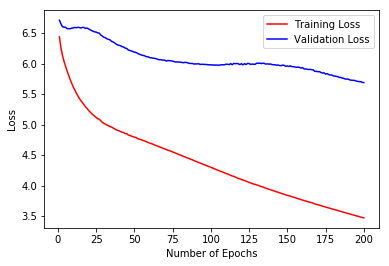

In [46]:
import matplotlib.pyplot as plt
plt.plot(Epochs_Losses.keys() , Epochs_Losses.values(), color = "red" , label = "Training Loss")
plt.plot(Validation_Losses.keys() , Validation_Losses.values(), color = "blue" , label = "Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [72]:
ClassesCorrectCount = {0:0 , 1:0 , 2:0 , 3:0 , 4:0}
Classes = ["daisy","dandelion", "roses","sunflowers","tulips"]
for i in range(testset.shape[0]): 
    NN.SetInput(testset[i].reshape(-1,3072))
    NNT = NeuralNetworkTrain(NN.NeuralNetwork, Epoch_Weights[198], Epoch_Bias[198])
    NNT.ForwardPass()
    Output = NN.NeuralNetwork[-1][0]
    Prediction = np.argmax(Output)
    if Prediction == testlabels[i]:
        ClassesCorrectCount[testlabels[i]] +=1
        
ClassAccuarcies ={}
for index in range(len(Classes)): 
    ClassAccuarcies[index] = ClassesCorrectCount[index] / 134

print("Class Correct Classification Count and Percentage: ")
for i in range(len(Classes)):
    print(Classes[i] +": %d , %f" % (ClassesCorrectCount[i] , ClassAccuarcies[i]))

Class Correct Classification Count and Percentage: 
daisy: 49 , 0.365672
dandelion: 77 , 0.574627
roses: 56 , 0.417910
sunflowers: 75 , 0.559701
tulips: 58 , 0.432836


In [73]:
print("Correct Count: %d / %d" % (sum(ClassesCorrectCount.values()) , testset.shape[0]))
ACCR = sum(ClassesCorrectCount.values()) / testset.shape[0]
print("ACCR: %f" % ACCR)

Correct Count: 315 / 670
ACCR: 0.470149
